In [1]:
import os
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES']='1'

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [2]:
plane = jnp.array(np.load("car.npy"))
mean_sample = plane.mean(0)
std_sample = plane.std(0)

(-1.1, 1.1, -1.1073302984237672, 1.092669701576233)

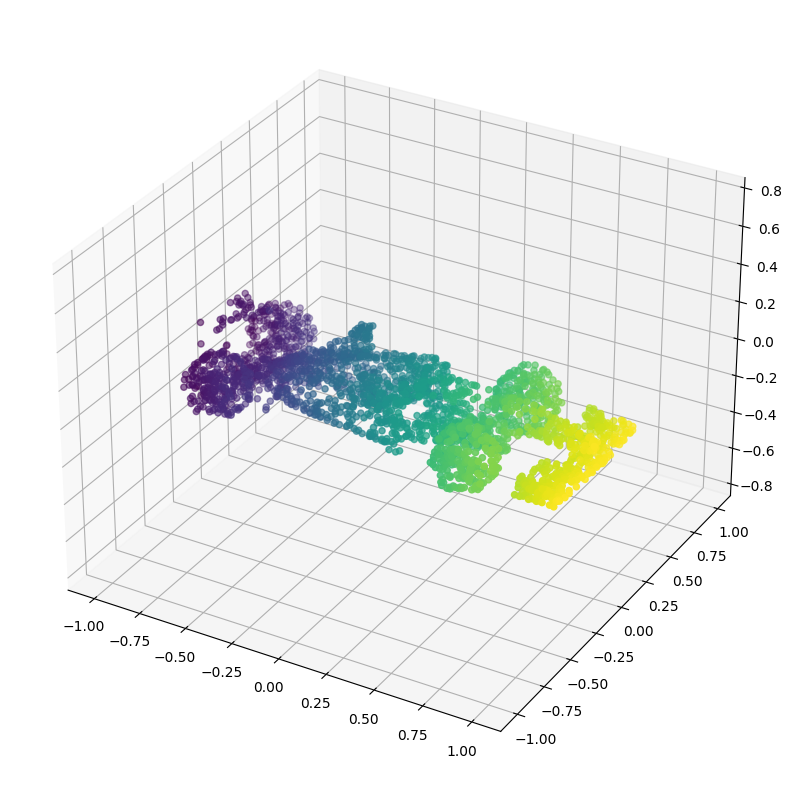

In [3]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection='3d')
ax.scatter(plane[:, 0], plane[:, 2], plane[:, 1],
            c=plane[:, 0], cmap='viridis')
plt.axis('equal')

## Norm Flows

In [4]:
from flowjax.flows import block_neural_autoregressive_flow, coupling_flow, triangular_spline_flow
from flowjax.train import fit_to_data
from flowjax.distributions import Normal
import jax.random as jr

data_key, flow_key, train_key, sample_key = jr.split(jr.key(0), 4)

flow = coupling_flow(
    key=flow_key,
    base_dist=Normal(loc=mean_sample, scale=std_sample),
    nn_activation=jax.nn.silu,
    nn_width=512,
    nn_depth=3,
    flow_layers=8
)

# flow = triangular_spline_flow(
#     key=flow_key,
#     base_dist=Normal(loc=mean_sample, scale=std_sample),
#     flow_layers=16,
#     tanh_max_val=1,
#     knots=16
# )
flow, losses = fit_to_data(
    key=train_key,
    dist=flow,
    x=plane,
    learning_rate=1e-4,
    batch_size=1024,
    max_patience=50,
    max_epochs=1000,
    )

# We can now evaluate the log-probability of arbitrary points
log_probs = flow.log_prob(plane)

# And sample the distribution
samples = flow.sample(sample_key, (plane.shape[0], ))

  4%|▍         | 42/1000 [00:03<01:09, 13.81it/s, train=0.4849583, val=0.5477534]  


KeyboardInterrupt: 

: 

(-26.359233355522157,
 25.737314915657045,
 -38.61745653152466,
 13.479091739654542)

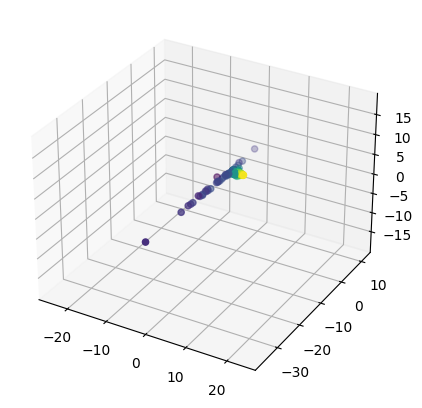

In [10]:
fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(projection='3d')
ax.scatter(samples[:, 0], samples[:, 2], samples[:, 1],
            c=samples[:, 0], cmap='viridis')
plt.axis('equal')

## Neural Dual

In [4]:
from functools import partial
from dataclasses import dataclass
from typing import Iterator

key = jax.random.PRNGKey(42)

class PlanesDataset:
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def __iter__(self):
        rng = jax.random.PRNGKey(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield PlanesDataset._sample(sample_key, self.batch_size)

    @staticmethod
    @partial(jax.jit, static_argnums=(1,))
    def _sample(key, batch_size):
        indx = jax.random.choice(key, a=plane.shape[0], replace=False, shape=(batch_size, ))
        return plane[indx]

class NoiseDataset:
    def __init__(self, batch_size, std, mean):
        self.batch_size = batch_size
        self.std_sample = std
        self.mean_sample = mean
        
    def __iter__(self):
        rng = jax.random.PRNGKey(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield NoiseDataset._sample(sample_key, self.batch_size, std_sample, mean_sample)

    @staticmethod
    @partial(jax.jit, static_argnums=(1,))
    def _sample(key, batch_size, std_sample, mean_sample):
        return jax.random.normal(key, (batch_size, 3)) * std_sample + mean_sample
    
@dataclass
class TrainLoader:
    src_loader: Iterator[jnp.ndarray]
    tgt_loader: Iterator[jnp.ndarray]
    
dataset_loader = TrainLoader(iter(NoiseDataset(1024, std=std_sample, mean=mean_sample)), iter(PlanesDataset(1024)))

(-1.9793821632862092,
 2.2140364706516267,
 -2.089055782556534,
 2.104362851381302)

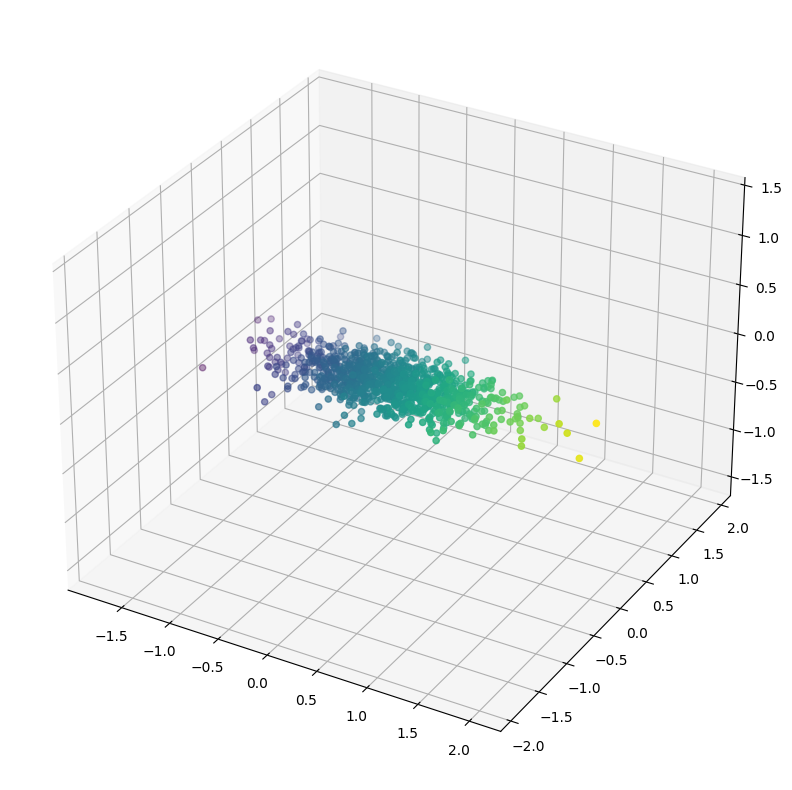

In [5]:
fig = plt.figure(figsize=(10, 10))
img = next(dataset_loader.src_loader)

ax = fig.add_subplot(projection='3d')
ax.scatter(img[:, 0], img[:, 2], img[:, 1],
            c=img[:, 0], cmap='viridis')
plt.axis('equal')

In [12]:
import optax
from ott.neural.methods import neuraldual
from ott.neural.networks import icnn, potentials

num_train_iters = 9_001

neural_f = icnn.ICNN(
    dim_data=2,
    dim_hidden=[128, 128, 128, 128],
    pos_weights=True,
    gaussian_map_samples=(
        next(dataset_loader.src_loader),
        next(dataset_loader.tgt_loader),
    ),  # initialize the ICNN with source and target samples
)

neural_g = potentials.PotentialMLP(
    act_fn=jax.nn.silu,
    dim_hidden=[128, 128, 128, 128],
    is_potential=False,  # returns the gradient of the potential.
)
lr_schedule = optax.cosine_decay_schedule(
    init_value=1e-2, decay_steps=num_train_iters, alpha=1e-2
)
optimizer_f = optax.adam(learning_rate=lr_schedule, b1=0.5, b2=0.5)
optimizer_g = optax.adam(learning_rate=lr_schedule, b1=0.9, b2=0.99)

neural_dual_solver = neuraldual.W2NeuralDual(
    3,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
    pos_weights=True,
)
learned_potentials = neural_dual_solver(
    trainloader_source=dataset_loader.src_loader,
    trainloader_target=dataset_loader.tgt_loader,
    validloader_source=dataset_loader.src_loader,
    validloader_target=dataset_loader.tgt_loader,
)

  0%|          | 0/9001 [00:00<?, ?it/s]

(-1.12460777759552, 1.1311986207962037, -1.1159174650907517, 1.139888933300972)

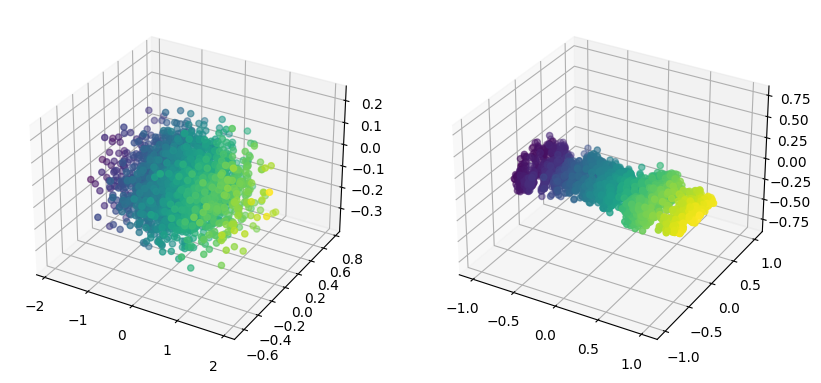

In [13]:
source_test = NoiseDataset._sample(jax.random.PRNGKey(42), plane.shape[0], std_sample, mean_sample)
pred = learned_potentials.transport(source_test)

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.scatter(source_test[:, 0], source_test[:, 2], source_test[:, 1],
            c=source_test[:, 0], cmap='viridis')
ax2.scatter(pred[:, 0], pred[:, 2], pred[:, 1],
            c=pred[:, 0], cmap='viridis')
plt.axis('equal')

In [14]:
np.save('amos_car.npy', arr=pred)

In [19]:
#np.save("amos_chair.npy", arr=pred)
# AFTER MITSUBA RENDERING AND POINTFLOW_FIG_COLORFUL.PY
import imageio
pointcloud_image = imageio.imread('amos_chair.exr')
imageio.imwrite('amos_chair.png', pointcloud_image, quality=100)

/tmp/ipykernel_407711/2999962191.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pointcloud_image = imageio.imread('amos_chair.exr')


In [25]:
import optax
from ott.neural.methods import neuraldual
from ott.neural.networks import icnn, potentials

num_train_iters = 5_001

neural_g = potentials.PotentialMLP(
    dim_hidden=[128, 128, 128],
    is_potential=True,  # returns the gradient of the potential.
)
neural_g = potentials.PotentialMLP(
    dim_hidden=[128, 128, 128],
    is_potential=True,  # returns the gradient of the potential.
)
lr_schedule = optax.cosine_decay_schedule(
    init_value=3e-4, decay_steps=num_train_iters, alpha=1e-3
)
optimizer_f = optax.adam(learning_rate=lr_schedule, b2=0.99)
optimizer_g = optimizer_f

neural_dual_solver = neuraldual.W2NeuralDual(
    3,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
)
learned_potentials = neural_dual_solver(
    trainloader_source=dataset_loader.src_loader,
    trainloader_target=dataset_loader.tgt_loader,
    validloader_source=dataset_loader.src_loader,
    validloader_target=dataset_loader.tgt_loader,
)

  0%|          | 0/5001 [00:00<?, ?it/s]

(-1095.6920318603516,
 1488.2783966064453,
 -1655.4729766845703,
 928.4974517822266)

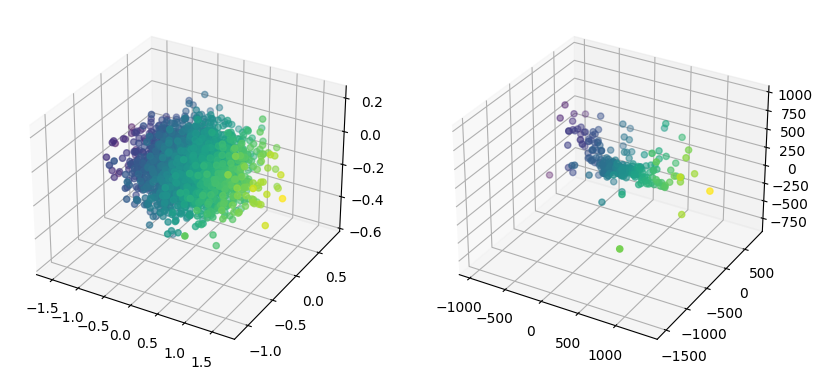

In [27]:
source_test = NoiseDataset._sample(jax.random.PRNGKey(42), plane.shape[0], std_sample, mean_sample)
pred = learned_potentials.transport(source_test)

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.scatter(source_test[:, 0], source_test[:, 2], source_test[:, 1],
            c=source_test[:, 0], cmap='viridis')
ax2.scatter(pred[:, 0], pred[:, 2], pred[:, 1],
            c=pred[:, 0], cmap='viridis')
plt.axis('equal')